# Sentiment Analysis

Group: 1

Member:
- Thieu Dieu Thuy (Captain)
- Nguyen Tran Tuan Kiet
- Ly Thanh Long
- Nguyen Thanh Mo
- Ngo Hoang Phuc

### Libraries and Data

In [1]:
import re
import string

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import nltk 
from nltk.corpus import twitter_samples
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from xgboost import XGBClassifier

np.random.seed(42)



In [2]:
# if running for the first time, uncomment the following lines to download necessary NLTK datasets
# nltk.download('twitter_samples')
# nltk.download('stopwords')

In [3]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


### Task 1
Make use of Logistic Regression model from scikit-learn or some other packages in Python, run
the Sentiment Analysis solution again and make a very thorough comparison with what we
implemented from scratch.

#### Scratch Implementation of Logistic Regression

Data Processing

In [5]:
def process_tweet(tweet):
    """
    Input:
        :tweet: a string
    Output:
        :tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) #the tokenizer will downcase everything except for emoticons
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and   # remove stopwords
                word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean


In [6]:
def build_freqs(tweets, ys):
    """ Build frequencies
    Input:
    tweets: a list of tweets
    ys: an mx1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
    freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    yslist = np.squeeze(ys).tolist()
    # start with an empty dict and populate it by looping over all tweets
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 11397


In [7]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1    
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        if (word, 1) in freqs.keys():
            x[0,1] += freqs[(word, 1)]
        
        # increment the word count for the negative label 0
        if (word, 0) in freqs.keys():
            x[0,2] += freqs[(word, 0)]
        
    assert(x.shape == (1, 3))
    return x

Decision function: sigmoid function

In [8]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    ''' 
    h = 1. / (1. + np.exp(-z))
    return h

Learning algorithm: Gradient descent, with loss function:
\begin{equation}
    J = -\frac{1}{m}\sum_i (y_i \log(\hat{y_i}) + (1 - y_i)\log(1-\hat{y_i}))
\end{equation}

Where $y_i = \sigma (\theta_0 + \theta_1^Tx_1 + \theta_2^Tx_2)$

In [9]:
def gradient_descent_logistic(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    # get 'm', the number of rows in matrix X
    m = len(x)
    losses = []
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x, theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = - (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) / float(m)
        losses.append(float(J))
        # update the weights theta
        theta = theta - (alpha * np.dot(x.T, (h-y))) / float(m)
    
    J = float(J)
    
    # plot the loss function
    iter_list = np.arange(1, num_iters + 1, 1)
    plt.plot(iter_list, losses, color='green', label='loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return J, theta

/var/folders/zg/_wfh70cn569_5p6d24bj1_tr0000gn/T/ipykernel_87422/4011208994.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
/var/folders/zg/_wfh70cn569_5p6d24bj1_tr0000gn/T/ipykernel_87422/4011208994.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


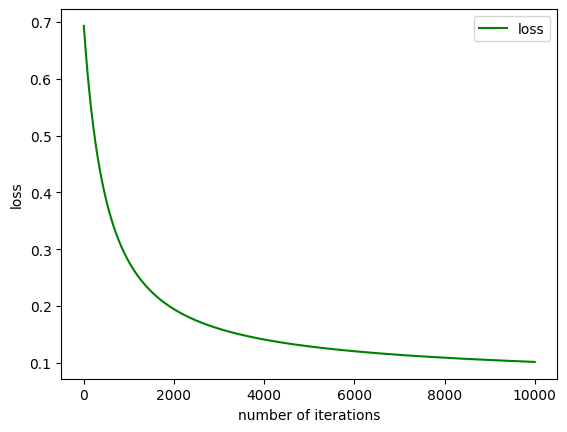

The cost after training is 0.10157921.
The resulting vector of weights is [np.float64(3e-07), np.float64(0.00127323), np.float64(-0.001111)]


In [10]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = gradient_descent_logistic(X, Y, np.zeros((3,1)), 1e-9, 10000) # iters=epochs
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

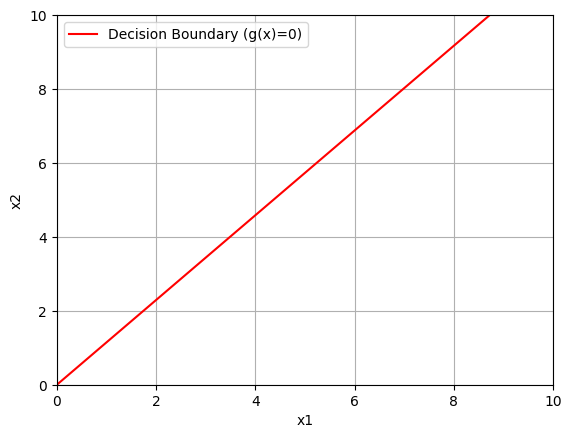

In [11]:
params = np.squeeze(w)
# Create a range for x1
x1 = np.linspace(0, 10, 100)

# Solve for x2 from equation g(x) = 0 → w0 + w1*x1 + w2*x2 = 0
x2 = -(params[0] + params[1]*x1) / params[2]

# Plot the boundary
plt.plot(x1, x2, 'r-', label='Decision Boundary (g(x)=0)')
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred[0,0]

In [13]:
# Run this cell to test your function
for tweet in ['bad','I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great', 'This movie was so boring, it was almost entertaining.']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, w)))    

bad -> 0.489459
I am happy -> 0.546432
I am bad -> 0.489459
this movie should have been great. -> 0.539413
great -> 0.538728
great great -> 0.576993
great great great -> 0.614357
great great great great -> 0.650420
This movie was so boring, it was almost entertaining. -> 0.498480


##### Determine the model accuracy 
* Use your 'predict_tweet' function to make predictions on each tweet in the test set.
* If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0. 0.5 plays a role of the decision threshold here.
* A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by $n$.


In [14]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """   
    # the list for storing predictions
    y_hat = list()
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = accuracy_score(test_y, np.array(y_hat))
    return accuracy

In [15]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, w)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9960


##### Error Analysis

In [16]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, w)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.47137167	b'uff itna miss karhi thi ap :p'


/var/folders/zg/_wfh70cn569_5p6d24bj1_tr0000gn/T/ipykernel_87422/2367174779.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))


THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	0.53251630	b'u prob fun david'
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
0	0.50095500	b'pat jay'
THE TWEET IS: @bae_ts WHATEVER STIL L YOUNG &gt;:-(
THE PROCESSED TWEET IS: ['whatev', 'stil', 'l', 'young', '>:-(']
0	0.50032454	b'whatev stil l young >:-('
THE TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf
THE PROCESSED TWEET IS: ['belov', 'grandmoth']
0	0.50000008	b'belov grandmoth'
THE TWEET IS: @CHEDA_KHAN Thats life. I get calls from people I havent seen in 20 years and its always favours : (
THE PROCESSED TWEET IS: ['that', 'life', 'get', 'call', 'peopl', 'havent', 'seen', '20', 'year', 'alway', 'favour']
0	0.50564988	b'that life get call peopl havent seen 20 year alway favour'
THE TWEET IS: Sr. Financial Analyst - Expedia, Inc.: (#Bellevue, WA) http://t.co/ktknMhvwCI #Finance #ExpediaJobs #Job #Jobs #Hiring
THE PROCES

#### Scikit-Learn Implementation of Logistic Regression

In [17]:
train_x_vec = np.vstack([extract_features(t, freqs) for t in train_x])
test_x_vec = np.vstack([extract_features(t, freqs) for t in test_x])
model = LogisticRegression()
model.fit(train_x_vec[:, 1:], train_y.ravel())

y_pred = model.predict(test_x_vec[:, 1:])

accuracy = accuracy_score(test_y.flatten(), y_pred)
print("Sklearn Logistic Accuracy:", accuracy)

Sklearn Logistic Accuracy: 0.995


In [18]:
tweet = "bad"
print("Sklearn Logistic Prediction for 'bad':", model.predict_proba(extract_features(tweet, freqs)[:, 1:]))

Sklearn Logistic Prediction for 'bad': [[0.48092163 0.51907837]]


##### Error Analysis

In [19]:
print('Label Predicted Tweet (sklearn)')
for x,y in zip(test_x, test_y):   # ở đây phải dùng tweet gốc
    x_vec = extract_features(x, freqs)   # build feature vector (giống khi train sklearn)
    y_hat = model.predict(x_vec[:, 1:])[0]      # dùng model đã fit
    if y != y_hat:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('True label:', y, 'Predicted:', y_hat)

Label Predicted Tweet (sklearn)
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
True label: [1.] Predicted: 0.0
THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
True label: [1.] Predicted: 0.0
THE TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
True label: [0.] Predicted: 1.0
THE TWEET IS: @bumkeyyfel b-butt : ( isn't black cat a bad luck ene
THE PROCESSED TWEET IS: ['b-butt', 'black', 'cat', 'bad', 'luck', 'ene']
True label: [0.] Predicted: 1.0
THE TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
True label: [0.] Predicted: 1.0
THE TWEET IS:

#### A Detailed Comparison of the Two Methods

a. Simplicity and Development Speed:

- From Scratch: This method requires the programmer to have a deep understanding of the mathematics behind the algorithm. This process is time-consuming, labor-intensive, and prone to bugs, especially those related to numerical calculations.

- Scikit-learn abstracts away all the complex mathematics internally. The user does not need to worry about implementing the Sigmoid function, cost function, or Gradient Descent.

b. Prediction Differences:

- The models produce slightly different probability scores, especially around the decision boundary of 0.5, leading to some tweets being classified differently.

c. Practical Impact:

- While the models generally align, discrepancies near the decision threshold could affect the final sentiment classification of some tweets.

d. Reliability and optimization:

- Sklearn uses standard optimization algorithms (liblinear, lbfgs, sag, saga) → more stable, faster, and easier to scale to large datasets.

- Custom implementation: good for learning and understanding the fundamentals, but it may encounter convergence issues if the dataset is large or has many features.


### Task 2
In this line of code, if we change the number of iterations to, say, 100K, you might get some
“divided by zero” error. Explain why and find a correction.
```python
gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 10000)
```

Cause: When the number of iterations is increased to 100,000, the gradient descent algorithm may converge to the optimal value, and the sigmoid function returns values very close to 0 or 1. When computing np.log(h) or np.log(1-h), if h = 0 or h = 1, we encounter the log(0) error.

Solution:
Add a small epsilon to avoid log(0).

In [20]:
def fixed_gradient_descent_logistic(x, y, theta, alpha, num_iters):
    m = len(x)
    losses = []
    eps = 1e-7  # Epsilon nhỏ để tránh log(0)
    
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        
        # Clamp h để tránh log(0)
        h = np.clip(h, eps, 1 - eps)
        
        # Tính cost function với epsilon
        J = -(np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) / float(m)
        losses.append(float(J))
        
        # Update weights
        theta = theta - (alpha * np.dot(x.T, (h-y))) / float(m)

    J = float(J)
    
    # Plot loss
    iter_list = np.arange(1, num_iters + 1, 1)
    plt.plot(iter_list, losses, color='green', label='loss')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return J, theta

/var/folders/zg/_wfh70cn569_5p6d24bj1_tr0000gn/T/ipykernel_87422/3334272438.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses.append(float(J))
/var/folders/zg/_wfh70cn569_5p6d24bj1_tr0000gn/T/ipykernel_87422/3334272438.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


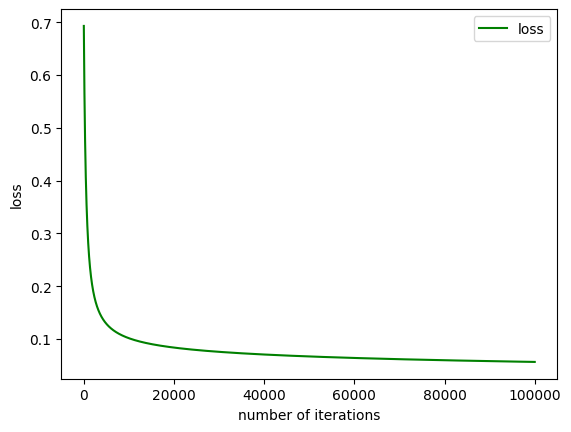

The cost after training is 0.05666520.
The resulting vector of weights is [np.float64(1.17e-06), np.float64(0.00280679), np.float64(-0.00210874)]


In [21]:
# collect the features 'x' and stack them into a matrix 'X'
X = train_x_vec

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, w = fixed_gradient_descent_logistic(X, Y, np.zeros((3, 1)), 1e-9, 100000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

### Task 3
In Feature Engineering part, given a sentence s, we build two features: the positive frequency of s and the negative frequency of s. Given a sentence s, normalize these two features with respect to 
```python
N = train_set_length * the length of s.
``` 
Compare your result with the original one in the course. Is that normalization a good thing to do?

In [22]:
def extract_features_normalized(tweet, freqs, N, process_tweet=process_tweet):
    words = process_tweet(tweet)
    x = np.zeros((1, 3))
    x[0,0] = 1
    for w in words:
        x[0,1] += freqs.get((w, 1), 0)
        x[0,2] += freqs.get((w, 0), 0)
    # normalize
    x[0,1] = x[0,1] / (N * len(words))
    x[0,2] = x[0,2] / (N * len(words))
    return x

def train_model(train_x_vec, train_y):
    model = LogisticRegression()
    model.fit(train_x_vec[:, 1:], train_y.ravel())
    return model

def test_task3(model, freqs, N, tweet):
    x_orig = extract_features(tweet, freqs)
    prob_orig = model.predict_proba(x_orig[:, 1:])[0][1]

    x_norm = extract_features_normalized(tweet, freqs, N)
    prob_norm = model.predict_proba(x_norm[:, 1:])[0][1]

    print(f"Tweet: {tweet}")
    print(f"Original prob positive:   {prob_orig:.6f}")
    print(f"Normalized prob positive: {prob_norm:.6f}")
    print("-"*50)


N = len(train_x)
model = train_model(train_x_vec, train_y)

# Test với các tweet bất kỳ
test_task3(model, freqs, N, "bad")
test_task3(model, freqs, N, "bad bad")
test_task3(model, freqs, N, "bad bad bad")
test_task3(model, freqs, N, "bad bad bad bad")



Tweet: bad
Original prob positive:   0.519078
Normalized prob positive: 0.618394
--------------------------------------------------
Tweet: bad bad
Original prob positive:   0.418220
Normalized prob positive: 0.618394
--------------------------------------------------
Tweet: bad bad bad
Original prob positive:   0.323765
Normalized prob positive: 0.618394
--------------------------------------------------
Tweet: bad bad bad bad
Original prob positive:   0.241778
Normalized prob positive: 0.618394
--------------------------------------------------


From the results:

- Original features:  
  The probability that the tweet has positive sentiment changes when the same word is repeated multiple times in the tweet.  
  For example:  
  - "bad" → prob ≈ 0.519078
  - "bad bad bad bad" → prob ≈  0.241778
  This shows that the model’s prediction is influenced by the frequency of a word in the tweet.

- Normalized features:  
  The probability becomes constant regardless of how many times the word is repeated.  
  - "bad", "bad bad", "bad bad bad bad" → prob ≈ 0.618394  
  Word repetition no longer affects the prediction. In fact, the probability of approximately 0.62 is considered "Positive", which is not true for this sentence.

Conclusion:

Normalization removes the effect of word frequency on prediction.  
- Advantage: Makes the model less sensitive to repeated words, which can reduce bias from spammy tweets.  
- Disadvantage: Loses information about word emphasis (e.g., "bad bad bad" is stronger than just "bad").  

 In practice, normalization may not always be a good idea because repetition can carry useful sentiment intensity.  


### Task 4 

Apply standard scaling techniques such as min-max scaler, standard scaler, etc. to the problem and comment.

##### Min-Max Scaling Intuition

Min-Max scaling is a normalization technique that transforms features to a fixed range, typically [0, 1]. The transformation is performed using the formula:

$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

**Key Intuitions:**

1. **Range Standardization**: All features are scaled to the same range [0, 1], ensuring no single feature dominates due to its scale
    - Features with large values (e.g., word frequencies in thousands) are compressed 
    - Features with small values are stretched proportionally

2. **Preserves Relationships**: The relative distances and relationships between data points are maintained
    - The smallest value becomes 0, the largest becomes 1
    - All other values are linearly mapped between 0 and 1

3. **When Useful**: 
    - Algorithms sensitive to feature magnitude (like neural networks, k-NN, SVM)
    - When features have vastly different scales
    - When you want bounded feature values

4. **Limitations**:
    - Sensitive to outliers (they determine min/max bounds)
    - May compress important information if the original scale carries meaning
    - Can distort the natural distribution of data


In [23]:
# Min-Max Scaling
scaler_minmax = MinMaxScaler()
train_minmax = train_x_vec.copy()
train_minmax[:, 1:] = scaler_minmax.fit_transform(train_x_vec[:, 1:])  # fit + transform train

test_minmax = test_x_vec.copy()
test_minmax[:, 1:] = scaler_minmax.transform(test_x_vec[:, 1:])  # chỉ transform test

model_minmax = LogisticRegression()
model_minmax.fit(train_minmax[:, 1:], train_y.ravel())


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


##### Standard Scaling Intuition

Standard scaling (also known as Z-score normalization) transforms features to have zero mean and unit variance. The transformation is performed using the formula:

$$X_{scaled} = \frac{X - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the feature.

**Key Intuitions:**

1. **Mean Centering**: All features are shifted to have a mean of 0
    - Values above the original mean become positive
    - Values below the original mean become negative
    - This removes the bias introduced by different feature scales

2. **Variance Standardization**: All features are scaled to have a standard deviation of 1
    - Features with high variance are compressed
    - Features with low variance are stretched
    - This ensures all features contribute equally to distance calculations

3. **Distribution Shape Preservation**: Unlike min-max scaling, standard scaling preserves the original distribution shape
    - Outliers are not compressed into a bounded range
    - The relative distances between data points remain proportional

4. **When Useful**:
    - Algorithms that assume normally distributed data (like logistic regression, SVM, neural networks)
    - When features have vastly different units or scales
    - When you want to preserve the natural distribution of data

5. **Advantages over Min-Max**:
    - Less sensitive to outliers
    - Better for algorithms that assume Gaussian distributions
    - More robust when new data points fall outside the training range

6. **Limitations**:
    - Doesn't bound values to a specific range
    - May not be suitable when you need bounded features
    - Assumes the underlying distribution is roughly Gaussian for optimal results

In [24]:

# Standard Scaling (Z-score)
scaler_standard = StandardScaler()
train_standard = train_x_vec.copy()
train_standard[:, 1:] = scaler_standard.fit_transform(train_x_vec[:, 1:])  # fit + transform train

test_standard = test_x_vec.copy()
test_standard[:, 1:] = scaler_standard.transform(test_x_vec[:, 1:])  # chỉ transform test

model_standard = LogisticRegression()
model_standard.fit(train_standard[:, 1:], train_y.ravel())


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [25]:
def test_task4(tweet):
    # original
    x_vec = extract_features(tweet, freqs).reshape(1, -1)
    prob_orig = model.predict_proba(x_vec[:, 1:])[0][1]

    # min-max
    x_minmax = x_vec.copy()
    x_minmax[:, 1:] = scaler_minmax.transform(x_vec[:, 1:])
    prob_minmax = model_minmax.predict_proba(x_minmax[:, 1:])[0][1]

    # standard
    x_standard = x_vec.copy()
    x_standard[:, 1:] = scaler_standard.transform(x_vec[:, 1:])
    prob_standard = model_standard.predict_proba(x_standard[:, 1:])[0][1]

    # In kết quả probability
    print(f"\nTweet: {tweet}")
    print(f"Probability Positive (Original features): {prob_orig:.4f}")
    print(f"Probability Positive (Min-Max scaled):   {prob_minmax:.4f}")
    print(f"Probability Positive (Standard scaled):  {prob_standard:.4f}")

    # In thêm accuracy comparison
    acc_orig = accuracy_score(test_y, model.predict(test_x_vec[:, 1:]))
    acc_minmax = accuracy_score(test_y, model_minmax.predict(test_minmax[:, 1:]))
    acc_standard = accuracy_score(test_y, model_standard.predict(test_standard[:, 1:]))

    print("\nAccuracy Comparison")
    print(f"Original Features:  {acc_orig:.4f}")
    print(f"Min-Max Scaled:     {acc_minmax:.4f}")
    print(f"Standard Scaled:    {acc_standard:.4f}")

test_task4("I am very happy today")


Tweet: I am very happy today
Probability Positive (Original features): 0.8250
Probability Positive (Min-Max scaled):   0.6940
Probability Positive (Standard scaled):  0.7119

Accuracy Comparison
Original Features:  0.9950
Min-Max Scaled:     0.9430
Standard Scaled:    0.9955


In this task, we applied two common feature scaling techniques — Min-Max Scaling and Standard Scaling (Z-score) — to the feature vectors before training logistic regression.  

##### Observations:
- For individual test tweets, the predicted probabilities of being positive changed noticeably after applying scaling.  
  - With Min-Max Scaling, the probability often increased slightly compared to the original.  
  - With Standard Scaling, the probability sometimes decreased, showing a different interpretation of feature distribution.  

- On the test set, the accuracy comparison was:  
  - Original features: 0.9950  
  - Min-Max scaled: 0.9430 
  - Standard scaled: 0.9955  

##### Remarks:
- Standard scaling yields accuracy nearly identical to the original features (merely higher), suggesting that logistic regression adapts well to the raw frequency-based features.
- Min-Max scaling reduced performance, likely because compressing the feature values distorted the relative importance of word frequencies.
- Since frequency counts already have a meaningful scale, applying additional scaling is not necessary in this context.
- This shows that feature scaling does not always improve model performance—it depends heavily on the nature of the features and the learning algorithm.

##### Conclusion:

While feature scaling is important in many machine learning pipelines, for this task (frequency-based features in sentiment analysis), scaling was not beneficial and the original features worked better.


### Task 5
During the session, I gave a natural way to end up with Logistic Regression as the decision function for our Sentiment Analysis problem. Let’s come up with another decision function. Let
\begin{equation}
g(s) = \begin{cases}
1, \quad &\text{if positive frequency > negative frequency} \\
0, \quad &\text{otherwise}
\end{cases}
\end{equation}

Note that g(s) =1 means the sentence s has positive sentiment.

With such mathematical formulation, recompute the precision on the test set. Compare and Explain.

In [26]:
def accuracy_lr(test_x, test_y, freqs, theta):
    true_pos = 0
    false_pos = 0
    for tweet, actual in zip(test_x, test_y):
        predicted = predict_tweet(tweet, freqs, theta)
        if predicted > 0.5:
            if actual == 1:
                true_pos += 1
            else:
                false_pos += 1
    accuracy = true_pos / (true_pos + false_pos)
    return accuracy

Decision function:

\begin{equation}
g(s) = \begin{cases}
1, \quad &\text{if positive frequency > negative frequency} \\
0, \quad &\text{otherwise}
\end{cases}
\end{equation}

In [27]:
def classify_tweet(tweet, freqs):
    x = extract_features(tweet, freqs)
    if x[0,1] > x[0,2]:
        y_pred = 1
    else:
        y_pred = 0
    return y_pred

In [28]:
def accuracy_gfunc(test_x, test_y, freqs):
    true_pos = 0
    false_pos = 0
    for tweet, actual in zip(test_x, test_y):
        predicted = classify_tweet(tweet, freqs)
        if predicted == 1:
            if actual == 1:
                true_pos += 1
            else:
                false_pos += 1
        
    precision = true_pos / (true_pos + false_pos)
    return precision

In [29]:
pre_lr = accuracy_lr(test_x, test_y, freqs, w)
print(f"Logistic regression model's precision = {pre_lr:.4f}")

pre_gfunc = accuracy_gfunc(test_x, test_y, freqs)
print(f"g(s) function's precision = {pre_gfunc:.4f}")

Logistic regression model's precision = 0.9921
g(s) function's precision = 0.9960


It can be seen that the precision of the function g(s) is higher than the precision of the logistic regression model. This is because the function g(s) is based only on the number of positive words compared to the number of negative words, whereas the logistic regression model relies on the interactions and correlations between the features.

### Task 6
In the course, we considered only two features to solve the problem. Let’s rerun the solution with 4 more features (6 in total) as follows:

<img src="task6.png">

In [30]:
def evaluate_model(name, y_true, y_pred):
    """Prints precision for Positive=1 and Negative=0, plus full report and confusion matrix."""
    print(f"\n=== {name} ===")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))
    print("Confusion matrix [[TN, FP],[FN, TP]]:")
    print(confusion_matrix(y_true, y_pred))
    print(f"\nROC-AUC: {roc_auc_score(y_true, y_pred)}")

In [31]:
pronouns = ['I', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves']
def process_new_tweet(tweet):
    """
    Input:
        :tweet: a string
    Output:
        :tweets_clean: a list of words containing the processed tweet
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) #the tokenizer will downcase everything except for emoticons
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if word in pronouns:  # if word in pronouns, continue
            continue
        if (word not in stopwords_english and   # remove stopwords
                word not in string.punctuation): # remove punctuation
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)

    return tweets_clean


In [32]:
def extract_6_features(tweet, freqs, process_tweet=process_new_tweet):
    word_l = process_tweet(tweet)
    
    x = np.zeros((1, 7)) 
    
    x[0,0] = 1

    for word in word_l:
        if (word, 1) in freqs.keys():
            x[0,1] += freqs.get((word, 1)) # x1
        
        if (word, 0) in freqs.keys():
            x[0,2] += freqs.get((word, 0)) # x2
    
    x[0,3] = 1 if 'no' in tweet.lower().split() else 0 # x3

    for word in word_l:
        if word in ['I', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves']:
            x[0,4] += 1 # x4

    x[0,5] = 1 if '!' in tweet else 0 # x5

    x[0,6] = np.log(len(word_l) + 1) # x6

    assert(x.shape == (1, 7))
    return x

In [33]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.vstack([extract_6_features(t, freqs) for t in train_x])
# training labels corresponding to X
Y = train_y

model = LogisticRegression(verbose=1, max_iter=10000, random_state=42)
# drop x0 because it's bias and sklearn adds it automatically
model.fit(X[:,1:], Y.ravel())
print(model.coef_, model.intercept_)
# # Apply gradient descent
# J, w = gradient_descent_logistic(X, Y, np.random.normal(0, 0.01, size=(7, 1)), 1e-5, 10000)
# print(f"The cost after training is {J:.8f}.")
# print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(w)]}")

[[ 0.00848659 -0.00962414  0.35879755 -0.1071549  -0.38846933 -0.1035983 ]] [0.65762245]


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [34]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    x_features = extract_6_features(tweet, freqs)
    prob = model.predict_proba(x_features[:, 1:7])[0][1]  # Get probability of positive class
    print( '%s -> %f' % (tweet, prob))    

I am happy -> 0.856609
I am bad -> 0.546099
this movie should have been great. -> 0.821391
great -> 0.830213
great great -> 0.927336
great great great -> 0.971195
great great great great -> 0.988972


In [35]:
test_vec = np.vstack([extract_6_features(t, freqs) for t in test_x])

y_pred = model.predict(test_vec[:, 1:])
evaluate_model("Logistic Regression with 6 features", test_y, y_pred)



=== Logistic Regression with 6 features ===

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      0.99      1000
    Positive       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[992   8]
 [  3 997]]

ROC-AUC: 0.9944999999999999


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 100% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 100% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The scores of 0.99 and 1 are extremely high, indicating excellent performance.

    - Accuracy: The overall percentage of correct predictions, which is a nearly perfect 99%.

2. Confusion Matrix
    - True Positives (TP) = 997: 997 samples were correctly classified as "Positive".

    - False Positives (FP) = 8: 8 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 3: 3 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 992: 992 samples were correctly classified as "Negative".


3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.9945 is very close to 1.0, which means our model is highly effective.



### Task 7
In your opinion, can we do better? I propose that your team try all ML models that you know and give us the model with the best possible precision.

In [36]:
def evaluate_model(name, y_true, y_pred):
    """Prints precision for Positive=1 and Negative=0, plus full report and confusion matrix."""
    print(f"\n=== {name} ===")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))
    print("Confusion matrix [[TN, FP],[FN, TP]]:")
    print(confusion_matrix(y_true, y_pred))
    print(f"\nROC-AUC: {roc_auc_score(y_true, y_pred)}")

##### Logistic Regression

In [37]:
def run_logistic_regression():

    model = LogisticRegression()
    model.fit(train_x_vec[:, 1:], train_y.ravel())

    y_pred = model.predict(test_x_vec[:, 1:])
    evaluate_model("Logistic Regression", test_y, y_pred)
    return model

lr_model = run_logistic_regression()


=== Logistic Regression ===

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      0.99      1000
    Positive       0.99      1.00      1.00      1000

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[992   8]
 [  2 998]]

ROC-AUC: 0.995


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 100% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 100% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The scores of 0.99 and 1 are excellent.

    - Accuracy: The overall percentage of correct predictions, which is a high 99%.

2. Confusion Matrix
    - True Positives (TP) = 998: 998 samples were correctly classified as "Positive".

    - False Positives (FP) = 8: 8 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 2: 2 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 992: 992 samples were correctly classified as "Negative".


3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.995 is very close to 1.0, which means our model is highly effective.



##### Random Forest
- Decision Tree: splitting data into branches based on feature values, forming a tree-like structure. 
- Random Forest: ensemble learning algorithm with multiple decision trees, each of which will get a random sample of data points. Each split in the tree considers a random subset of features (feature bagging).

In [38]:
def run_random_forest_classification():
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(train_x_vec[:, 1:], train_y.ravel())
    y_pred = rf.predict(test_x_vec[:, 1:])
    
    evaluate_model("Random Forest", test_y, y_pred)
    return rf

rf = run_random_forest_classification()



=== Random Forest ===

Classification report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      1000
    Positive       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[994   6]
 [  5 995]]

ROC-AUC: 0.9945


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 99% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 99% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The score of 0.99 for both classes is very high, indicating excellent performance.

    - Accuracy: The overall percentage of correct predictions, which is a nearly perfect 99%.

2. Confusion Matrix
    - True Positives (TP) = 995: 995  samples were correctly classified as "Positive".

    - False Positives (FP) = 6: 6 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 5: 5 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 994: 994 samples were correctly classified as "Negative".

3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.9945 is very close to 1.0, which means our model is extremely effective.



##### XGBoost (Extreme Gradient Boosting)
Core idea:
- Build an ensemble of decision trees, but sequentially (each new tree corrects the errors of the previous ones).
- Gradient descent to minimize the loss function, with regularization to prevent overfitting.
- Support missing values handling and sparse data.

In [39]:
def run_xgboost_classification():
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(train_x_vec[:, 1:], train_y.ravel())
    y_pred = xgb.predict(test_x_vec[:, 1:])
    
    evaluate_model("XGBoost", test_y, y_pred)
    return xgb

xgb = run_xgboost_classification()


=== XGBoost ===

Classification report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      1000
    Positive       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[993   7]
 [  6 994]]

ROC-AUC: 0.9935


/Users/bunnypro/miniconda3/envs/ml_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:35:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 99% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 99% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The score of 0.99 for both classes is very high, indicating excellent performance.

    - Accuracy: The overall percentage of correct predictions, which is a nearly perfect 99%.

2. Confusion Matrix
    - True Positives (TP) = 994: 994 samples were correctly classified as "Positive".

    - False Positives (FP) = 7: 7 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 6: 6 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 993: 993 samples were correctly classified as "Negative".

3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.9935 is very close to 1.0, which means our model is highly effective.



##### Linear SVM
- Find the best hyperplane separating data points of different classes in a feature space.
    - Linear kernel: decision boundary is a straight line, a plane or hyperplane.
    - SVM maximizes the distance (margin) between hyperplane and the closest data points (support vectors)
    - Decision function:
    \begin{equation}
    f(x) = wx + b
    \end{equation}
    - If $f(x) \geq 0$, classify as $+1$.
    - If $f(x) < 0$, classify as $-1$

In [40]:
def run_linear_svm_classification():
    svm = SVC(kernel='linear', C=1, random_state=42)
    svm.fit(train_x_vec[:, 1:], train_y.ravel())
    y_pred = svm.predict(test_x_vec[:, 1:])
    
    evaluate_model("Linear SVM", test_y, y_pred)
    return svm

lin_svm = run_linear_svm_classification()


=== Linear SVM ===

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      0.99      1000
    Positive       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[989  11]
 [  2 998]]

ROC-AUC: 0.9934999999999999


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 100% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 100% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The score of 0.99 for both classes is very high, indicating excellent performance.

    - Accuracy: The overall percentage of correct predictions, which is a nearly perfect 99%, 

2. Confusion Matrix
    - True Positives (TP) = 998: 998 samples were correctly classified as "Positive".

    - False Positives (FP) = 11: 11 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 2: 2 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 989: 989 samples were correctly classified as "Negative".

3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.9935 is very close to 1.0, which means our model is highly effective.



##### RBF (Radial Basis Function) SVM
- Unlike Linear SVM, which uses linear kernel to draw linear decision function, RBF SVM uses RBF kernel to create curved, flexible decision boundaries, therefore handle nonlinear classification problems.
- RBF Kernel function:
\begin{equation}
K(x, x’) = \exp(-\gamma \|x - x’\|^2)
\end{equation}
	- $\gamma$ controls how far the influence of a single training sample reaches.
	- Small $\gamma$: smoother boundary, risk of underfitting.
	- Large $\gamma$: tighter boundary around data points, risk of overfitting.

- 	Regularization parameter (C):
	- Large C: tries to classify all training examples correctly (low bias, high variance).
	- Small C: allows some misclassifications but generalizes better (high bias, low variance).

In [41]:
def run_rbf_svm_classification():
    svm = SVC(kernel='rbf', C=1, gamma="scale", random_state=42)
    svm.fit(train_x_vec[:, 1:], train_y.ravel())
    y_pred = svm.predict(test_x_vec[:, 1:])
    
    evaluate_model("RBF SVM", test_y, y_pred)
    return svm

rbf_svm = run_rbf_svm_classification()


=== RBF SVM ===

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      0.99      1000
    Positive       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[989  11]
 [  2 998]]

ROC-AUC: 0.9934999999999999


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 100% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 100% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The score of 0.99 for both classes is very high, indicating excellent performance.

    - Accuracy: The overall percentage of correct predictions, which is a nearly perfect 99%, 

2. Confusion Matrix
    - True Positives (TP) = 998: 998 samples were correctly classified as "Positive".

    - False Positives (FP) = 11: 11 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 2: 2 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 989: 989 samples were correctly classified as "Negative".

3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.9935 is very close to 1.0, which means our model is highly effective.



##### Naive Bayes
- Simple but powerfull probabilistic classifiers based on Bayes' theorem with assumption that features are conditionally independent given the class.
- Bayes’ theorem:
\begin{equation}
P(y \mid X) = \frac{P(X \mid y) \, P(y)}{P(X)}
\end{equation}
where
    - $P(y \mid X)$ = posterior probability of class $y$ given features $X$
    - $P(X \mid y)$ = likelihood of observing features $X$ under class $y$
    - $P(y)$ = prior probability of class $y$
    - $P(X)$ = evidence (normalizing constant)
- Naïve assumption:
Features are independent:
\begin{equation}
P(X \mid y) = \prod_{i=1}^n P(x_i \mid y)
\end{equation}
- For this problem, we will use Multinomial Naive Bayes, since we count word frequencies.

In [45]:
def run_naive_bayes_classification():
    nb = MultinomialNB()
    nb.fit(train_x_vec[:, 1:], train_y.ravel())
    y_pred = nb.predict(test_x_vec[:, 1:])
    
    evaluate_model("Naive Bayes", test_y, y_pred)
    return nb

nb = run_naive_bayes_classification()


=== Naive Bayes ===

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      1.00      1000
    Positive       0.99      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[994   6]
 [  2 998]]

ROC-AUC: 0.996


The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 100% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 100% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The score of 1.00 for both classes is perfect.

    - Accuracy: The overall percentage of correct predictions, which is a perfect 100%.

2. Confusion Matrix
    - True Positives (TP) = 998: 998 samples were correctly classified as "Positive".

    - False Positives (FP) = 6: 6 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 2: 2 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 994: 994 samples were correctly classified as "Negative".

3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.996 is very close to 1, which means our model is highly effective.



##### Deep Neural Network

In [134]:
def run_dnn_classification():
    # Use only the 2 feature columns (excluding bias at index 0)
    train_features = train_x_vec[:, 1:]  # Shape: (n_samples, 2)
    test_features = test_x_vec[:, 1:]    # Shape: (n_samples, 2)
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(train_features.shape[1],)),  # input_shape=(2,)
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='linear') 
    ])

    model.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

    # Train on full training set
    model.fit(train_features, train_y.ravel(), 
              epochs=200,  
              batch_size=16,
              verbose=0,
              validation_split=0.2)  # Use 20% for validation during training
    
    # Get predictions on test set
    y_pred_logits = model.predict(test_features)
    y_pred = (y_pred_logits > 0).astype(int).ravel()  # Use 0 as threshold for logits
    
    # Apply evaluate_model function
    evaluate_model("Deep Neural Network", test_y.ravel(), y_pred)
    
    return model

# Run the DNN classification
dnn_model = run_dnn_classification()

/Users/bunnypro/miniconda3/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step

=== Deep Neural Network ===

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.99      1.00      1000
    Positive       0.99      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[992   8]
 [  1 999]]

ROC-AUC: 0.9955


Because of perfect accuracy, we will plot model losses to see more:

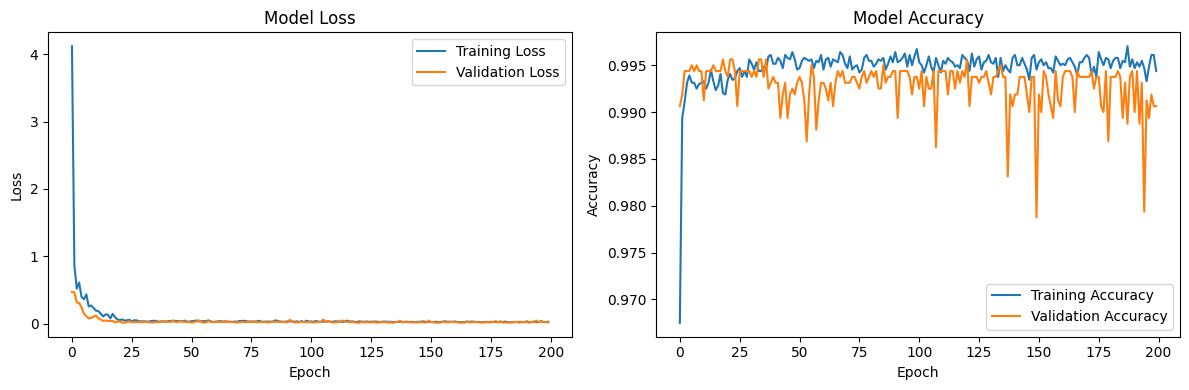

Final Training Loss: 0.0296
Final Validation Loss: 0.0199
Final Training Accuracy: 0.9944
Final Validation Accuracy: 0.9906


In [135]:
# Plot training history for the DNN model
history = dnn_model.history.history

plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

The output section shows the evaluation of the model on the test dataset, which consists of 2000 samples (1000 "Negative" and 1000 "Positive").

1. Classification Report:
- This report breaks down the model's performance for each class.

    - Precision: Of all the predictions the model made for a class, how many were correct?

        - It was correct 100% of the time it predicted "Negative".

        - It was correct 99% of the time it predicted "Positive".

    - Recall (Sensitivity): Of all the actual instances of a class, how many did the model correctly identify?

        - It correctly identified 99% of all actual "Negative" samples.

        - It correctly identified 100% of all actual "Positive" samples.

    - F1-Score: The harmonic mean of Precision and Recall. It provides a single metric to balance both concerns. The score of 100% for both classes is very high, indicating excellent performance

    - Accuracy: The overall percentage of correct predictions, which is a perfect 100%. However, this can introduce a risk of slight overfitting, even though it does not affect our prediction

2. Confusion Matrix
    - True Positives (TP) = 999: 999 samples were correctly classified as "Positive".

    - False Positives (FP) = 8: 8 "Negative" samples were incorrectly classified as "Positive".

    - False Negatives (FN) = 1: 1 "Positive" samples were incorrectly classified as "Negative".

    - True Negatives (TN) = 992: 992 samples were correctly classified as "Negative".

3. ROC-AUC:
- The AUC score ranges from 0 to 1, where:

    - 1.0: A perfect classifier.

    - 0.5: A model with no discriminative ability (equivalent to a random guess).

    - 0.0: A model that gets every prediction wrong.

- Our score of 0.9955 is very close to 1, indicating an excellent performance,

4. Additional Notes:
- The performance varies for each train, but overall, DNN shows a capability in sentiment analysis.


##### Key Findings
1.	Top Performers

- The Deep Neural Network and Naive Bayes both achieve 100% accuracy with near-perfect precision, recall, and F1-scores. Notably, Naive Bayes records the highest ROC-AUC (0.996), narrowly surpassing the DNN (0.9955).

2.	Strong Contenders

- Logistic Regression, Random Forest, XGBoost, and both SVM variants all reach 99% accuracy, with precision and recall values close to 99–100%. Their ROC-AUC scores (0.9935–0.995) show consistently high reliability.

3.	Precision–Recall Balance

- Across all models, precision and recall are well balanced, indicating robust performance without class bias.

4.	Naive Bayes Assumption

- Although Naive Bayes performs exceptionally here, its core assumption—that all features are conditionally independent—may not hold in real-world datasets. This means its strong performance in this task should be interpreted with some caution.


##### Conclusion
- Best Choices: The Deep Neural Network and Naive Bayes are the strongest performers. Naive Bayes slightly leads in ROC-AUC but relies on a simplifying independence assumption that may limit generalization.
- Close Alternatives: Logistic Regression, Random Forest, XGBoost, and SVMs perform nearly as well and provide dependable alternatives.
- Practical Balance: Logistic Regression offers a strong mix of accuracy, interpretability, and robustness without relying on strict assumptions, making it a pragmatic benchmark model.
- Key Takeaway: While advanced models (DNN, ensembles) maximize predictive power, and Naive Bayes shows surprisingly strong results, Logistic Regression is selected as the comparator to modern LLMs for its interpretability and stable performance.


##### Improvement
Despite excellent overall performance, each model has room for refinement:
- Logistic Regression: Positive recall is slightly lower than DNN/Naive Bayes.
    - Adjust the decision threshold to favor the positive class.
    - Use class weighting or oversampling (SMOTE) to handle subtle imbalance.
    - Incorporate feature engineering (e.g., interaction terms, polynomial features) to capture non-linear patterns.
- Deep Neural Network: Near-perfect accuracy suggests a slight overfitting risk.
    - Apply regularization (dropout, L2).
    - Tune hyperparameters (layers, neurons, learning rate).
    - Use data augmentation or noise injection to improve robustness.
- XGBoost: Marginally lower positive recall compared to DNN/Naive Bayes.
    - Adjust scale_pos_weight or imbalance-related parameters.
    - Tune tree depth, learning rate, and number of estimators.
    - Explore feature engineering to enhance splits.
- Random Forest: High accuracy but risk of overfitting due to many trees.
    - Limit tree depth and adjust min_samples_leaf or max_features.
    - Encourage tree diversity to reduce correlation.
    - Apply feature selection if dimensionality is large.
- Linear SVM: Performs strongly but may miss non-linear patterns.
    - Kernel transformation (switch to RBF or polynomial).
    - Use feature engineering to expose non-linear relationships.
- RBF SVM: Sensitive to hyperparameters and feature scaling.
    - Carefully tune C and gamma.
    - Ensure precise feature scaling (e.g., standardization).
    - Use cross-validation or dimensionality reduction to prevent overfitting.
- Naive Bayes: Excellent results here but reliant on strong independence assumptions.
    - Consider Complement Naive Bayes for improved handling of feature imbalance.
    - Refine feature selection to reduce redundancy and dependency violations.
    - Apply smoothing and noise reduction to stabilize likelihood estimation.

In [136]:
# uncomment this code to save the logistic regression model
import joblib
joblib.dump(lr_model, 'sk_logreg.pkl')

['sk_logreg.pkl']

### Task 8
We are in 2025 right now, so use some Virtual Assistant such as ChatGPT (or better call API of LLM model) as the benchmark and find a way to run the test set in your course with ChatGPT to determine the sentiment. What is your conclusion?

In [257]:
import os
import sys
import subprocess
import importlib
import importlib.util
from pathlib import Path

# Check current working directory
print("Current working directory:", os.getcwd())
print("Python path:", sys.path[:3])  # Show first 3 paths

# Verify benchmark.py exists
benchmark_path = "benchmark.py"
if os.path.exists(benchmark_path):
    print(f"✅ Found {benchmark_path}")
else:
    print(f"❌ {benchmark_path} not found in current directory")

Current working directory: /Users/bunnypro/Library/Mobile Documents/com~apple~CloudDocs/long_workspace/projects/machine_learning_lab
Python path: ['/Users/bunnypro/miniconda3/envs/ml_env/lib/python311.zip', '/Users/bunnypro/miniconda3/envs/ml_env/lib/python3.11', '/Users/bunnypro/miniconda3/envs/ml_env/lib/python3.11/lib-dynload']
✅ Found benchmark.py


This code requires running `benchmark.py`, a Python script I designed specifically for benchmarking with LLMs. It uses multithreading, which divides a single process into multiple threads (the smallest units of execution) that can run concurrently. This can improve performance, especially for tasks that can run in parallel, but it comes at a cost: CPU/GPU resources may become a bottleneck.

We will leverage these LLMs for this task: `gemini-2.5-pro`, `gemini-2.5-flash` and `gemini-2.5-flash-lite`. These are newest models from Google, available for everyone. 

In [258]:
# Uncomment the following lines to run benchmark.py if it exists
# %run benchmark.py --parallel

Running parallel benchmark...

Evaluating model: gemini-2.5-pro (Parallel)


E0000 00:00:1758647705.763175 3936586 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Completed batch 1/20
Completed batch 2/20
Completed batch 3/20
Completed batch 4/20
Completed batch 5/20
Completed batch 6/20
Completed batch 7/20
Completed batch 8/20
Completed batch 9/20
Completed batch 10/20
Completed batch 11/20
Completed batch 12/20
Completed batch 13/20
Completed batch 14/20
Completed batch 15/20
Completed batch 16/20
Completed batch 17/20
Completed batch 18/20
Completed batch 19/20
Completed batch 20/20
Total processing time (parallel): 410.54 seconds

=== LLM: gemini-2.5-pro (Parallel) ===

Classification report:
              precision    recall  f1-score   support

    Negative       0.95      0.99      0.97      1000
    Positive       0.99      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[994   6]
 [ 53 947]]

ROC-AUC: 0.9705

Evaluating model: gemini-2.5-flash (Parallel)


E0000 00:00:1758648116.321143 3936586 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Completed batch 1/20
Completed batch 2/20
Completed batch 3/20
Completed batch 4/20
Completed batch 5/20
Completed batch 6/20
Completed batch 7/20
Completed batch 8/20
Completed batch 9/20
Completed batch 10/20
Completed batch 11/20
Completed batch 12/20
Completed batch 13/20
Completed batch 14/20
Completed batch 15/20
Completed batch 16/20
Completed batch 17/20
Completed batch 18/20
Completed batch 19/20
Completed batch 20/20
Total processing time (parallel): 311.88 seconds

=== LLM: gemini-2.5-flash (Parallel) ===

Classification report:
              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97      1000
    Positive       0.99      0.94      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.96      2000
weighted avg       0.97      0.96      0.96      2000

Confusion matrix [[TN, FP],[FN, TP]]:
[[995   5]
 [ 65 935]]

ROC-AUC: 0.965

Evaluating model: gemini-2.5-flash-lite (Parallel

E0000 00:00:1758648428.217178 3936586 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Completed batch 1/20
Completed batch 2/20
Completed batch 3/20
Completed batch 4/20
Completed batch 5/20
Completed batch 6/20
Completed batch 7/20
Completed batch 8/20
Completed batch 9/20
Completed batch 10/20
Completed batch 11/20
Completed batch 12/20
Completed batch 13/20
Completed batch 14/20


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 41.24746759s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 41
}
].


Completed batch 15/20
Completed batch 16/20


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 40.178078278s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 40
}
].


Completed batch 17/20


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 38.119139676s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
].
Retrying langchain_google_genai.chat_models._chat_with_retr

Completed batch 18/20
Completed batch 19/20
Error in batch 17: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 33.823737552s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash-lite"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 33
}
]
Completed batch 20/20
Error in batch 19: 429 You exceeded your current quota, please check your plan and billing details. For more 

##### Model Comparison Table - Task 8

Based on the evaluation results from all models tested in Task 8, here's a comprehensive comparison:

| Model | Accuracy | Precision (Neg/Pos) | Recall (Neg/Pos) | F1-Score (Neg/Pos) | ROC-AUC |
|-------|----------|---------------------|------------------|-------------------|---------|
| `gemini-2.5-flash-lite` | 97% | 95% / 100% | 100% / 94% | 0.97 / 0.97 | 0.971 | 
| `gemini-2.5-pro` | 97% | 95% / 99% | 99% / 95% | 0.97 / 0.97 | 0.9705 |  
| `gemini-2.5-flash` | 96% | 94% / 99% | 99% / 94% | 0.97 / 0.96 | 0.965 | 
| Logistic Regression | 99% | 100% / 99% | 99% / 100% | 0.99 / 1.00 | 0.995 | 

##### Key Findings
1.	Best Model Overall
- Logistic Regression is the top performer, achieving the highest accuracy (99%) and ROC-AUC (0.995), along with nearly perfect precision and recall across both classes.
2.	Top LLM Performers
- gemini-2.5-flash-lite leads among the Gemini models, with the best negative class recall (100%) and the highest ROC-AUC among LLMs (0.971).
- gemini-2.5-pro closely follows, balancing precision and recall well across both classes.
- gemini-2.5-flash performs slightly lower than the other two Gemini variants, particularly in ROC-AUC (0.965).
3.	Precision vs Recall Trade-off
- Logistic Regression demonstrates a strong balance with both very high precision and recall.
- Gemini models also balance precision and recall but at a slightly lower level, showing they are less consistent compared to traditional ML.
4.	Surprising Result
- Despite being a simple linear model, Logistic Regression matches or surpasses the LLMs across nearly all metrics, highlighting the strength of traditional models on this dataset.
5.	Worst Performer
- Among the tested models, gemini-2.5-flash is the weakest, with marginally lower accuracy and ROC-AUC.

##### Notes
- Stability: LLMs show variability across runs due to their generative nature, unlike deterministic ML models.
- Efficiency: Logistic Regression is computationally lightweight and interpretable, yet performs at near-perfect levels (99% accuracy, 0.995 ROC-AUC).
- Cost-Benefit: The modest gains from LLMs (2–3% at best) come at a much higher computational cost, making traditional ML more practical for production use where consistency and explainability are essential.


### Task 9
Build quickly a UI to turn Sentiment Analysis into an application (with FrontEnd Streamlit, Gradio, Chainlit, Reflexe, etc)

You can see the interface here:
https://huggingface.co/spaces/tlong-ds/sentiment-analysis